## HW
#### Mountain Car Example

#### 1. Initializing

##### 1-1. IHT


In [1]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed.
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)),
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile
coordinates are to be returned without being converted to indices).
"""

from math import floor, log
from itertools import zip_longest

basehash = hash

class IHT:
    """Structure to handle collisions"""

    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        """Prepares a string for printing whenever this object is printed"""
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count(self):
        return len(self.dictionary)

    def fullp(self):
        return len(self.dictionary) >= self.size

    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount == 0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count


def hashcoords(coordinates, m, readonly=False):
    if type(m) == IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m) == int: return basehash(tuple(coordinates)) % m
    if m == None: return coordinates


def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // numtilings)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


def tileswrap(ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b % numtilings) // numtilings
            coords.append(c % width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

#### 1-2 module & params

In [2]:
import numpy as np
import numpy.random as random
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

iht = IHT(4096)
alpha = 0.1
gamma = 1
m = 8
w = np.zeros(4096)
num_episodes = 9000

#### 2. Functions

In [3]:
def active_tiles(x, xdot, A):
    return tiles(iht, 8, [8*x/(0.5+1.2), 8*xdot/(0.07+0.07)], [A])


def argmax_q(x, xdot):
    _argmax = 0
    q_value = q(x, xdot, a=0)
    for action in [-1, 0, 1]:
        if q(x, xdot, a=action) > q_value:
            _argmax = action
            q_value = q(x, xdot, a=action)
    return _argmax


def choose_action(x, xdot, epsilon=0.1):
    if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
        return np.random.choice([-1, 0, 1])
    else:
        return argmax_q(x, xdot)


def q(x, xdot, a=0):
    result = 0.
    tile_idx = active_tiles(x, xdot, a)
    for i, t in enumerate(tile_idx):
        result += w[t]
    return result


def bound(x, low, high):
    if x < low:
        return low
    elif x > high:
        return high
    return x


def take_action(x, xdot, A):
    xdot_ = bound(xdot + 0.001*A - 0.0025 * math.cos(3*x), -0.07, 0.07)
    x_ = bound(x+xdot_, -1.2, 0.5)
    if x_ == -1.2:
        xdot_ = 0
    return x_, xdot_


def draw_plot():

    def max_q(x, xdot):
        q_value = q(x, xdot, a=0)
        for action in range(-1, 2):
            if q(x, xdot, a=action) < q_value:
                q_value = q(x, xdot, a=action)
        return -q_value

    x_axis = np.linspace(-1.2, 0.5, 200)
    y_axis = np.linspace(-0.07, 0.07, 200)

    v = np.zeros((200, 200))
    for i in range(200):
        for j in range(200):
            v[i][j] = max_q(x_axis[i], y_axis[j])*0.2

    x_axis, y_axis = np.meshgrid(x_axis, y_axis)
    ax = plt.axes(projection='3d')
    # ax.set_xlim(-1.2, 0.5)
    # ax.set_ylim(-0.07, 0.07)
    ax.plot_wireframe(np.array(x_axis), np.array(y_axis), v)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('cost-to-go')
    plt.show()

#### 3. Run & Results

In [4]:
for ep in range(num_episodes):
    x, xdot = random.uniform(low=-0.6, high=-0.4), 0  # initial state
    A = choose_action(x, xdot)
    step = 0
    while True:
        step += 1
        x_, xdot_ = take_action(x, xdot, A)
        R = -1
        if x_ >= 0.5:  # terminal state
            for i, t in enumerate(active_tiles(x, xdot, A)):
                w[t] += (alpha/m)*(R-q(x, xdot, A))
            break
        A_ = choose_action(x_, xdot_)
        for i, t in enumerate(active_tiles(x, xdot, A)):
            w[t] += (alpha/m) * (R + gamma*q(x_, xdot_, A_) - q(x, xdot, A))
        x, xdot, A = x_, xdot_, A_
    print("[epoch %d] step: %d" % (ep+1, step))

Streaming output truncated to the last 5000 lines.
[epoch 4001] step: 113
[epoch 4002] step: 152
[epoch 4003] step: 152
[epoch 4004] step: 259
[epoch 4005] step: 111
[epoch 4006] step: 176
[epoch 4007] step: 156
[epoch 4008] step: 157
[epoch 4009] step: 114
[epoch 4010] step: 157
[epoch 4011] step: 114
[epoch 4012] step: 153
[epoch 4013] step: 150
[epoch 4014] step: 154
[epoch 4015] step: 155
[epoch 4016] step: 115
[epoch 4017] step: 120
[epoch 4018] step: 111
[epoch 4019] step: 175
[epoch 4020] step: 153
[epoch 4021] step: 154
[epoch 4022] step: 107
[epoch 4023] step: 157
[epoch 4024] step: 114
[epoch 4025] step: 113
[epoch 4026] step: 113
[epoch 4027] step: 116
[epoch 4028] step: 115
[epoch 4029] step: 115
[epoch 4030] step: 118
[epoch 4031] step: 114
[epoch 4032] step: 118
[epoch 4033] step: 117
[epoch 4034] step: 159
[epoch 4035] step: 190
[epoch 4036] step: 119
[epoch 4037] step: 113
[epoch 4038] step: 111
[epoch 4039] step: 153
[epoch 4040] step: 121
[epoch 4041] step: 112
[epoch

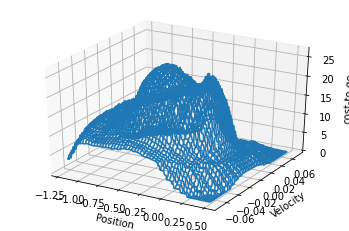

In [5]:
draw_plot()